## 30 Day Map Challenge - 11/27 -  Heatmaps: United States COVID-19 Testing Sites

Also known as hotspot maps, heatmaps are useful for visualizing point density. They can be used to show relative densities of COVID-19 testing sites in the United States. This project will analyze testing across several states. It will include overlays for population and political representation (by party). 

Technology Summary -
* ArcGIS Notebook -A Jupyter Notebook environment. Docker image of latest version from ESRI.
* Leaflet - Open source ipynb


In [148]:
import arcgis
from arcgis.gis import GIS 
import pandas as pd
from datetime import datetime as dt
from IPython.display import display

my_gis = GIS() 

In [57]:
# import dataset from AGOL using item id
item_id = 'd7d10caf1cec43e0985cc90fbbcf91cb' # GISCorps COVID-19 Testing Locations in the United States Symbolized by Status
ago_item = my_agol.content.get(item_id)
ago_item

<Item title:"GISCorps COVID-19 Testing Locations in the United States Symbolized by Test Type" type:Feature Layer Collection owner:htorpey_GC>

## 1.) Heatmap testing sites in Pennsylvania
* What does a heatmap over the state show?

In [108]:
# convert from item to feature layer then create local spatial dataframe with point geometry
fl_sites = ago_item.layers[0] 

us_state = 'PA'
searchby_state = f"State='{us_state}' "
sdf_sites_pa = fl_sites.query(where= searchby_state,
                           return_geometry=True,
                           as_df=True)

In [68]:
print(f'Shape of Dataframe: \n{sdf_sites.shape}')

Shape of Dataframe: 
(1134, 51)


In [69]:
print(f'Columns in COVID-19 Testing Sites Layer: \n{list(sdf_sites.columns)}')

Columns in COVID-19 Testing Sites Layer: 
['OBJECTID', 'facilityid', 'name', 'fulladdr', 'municipality', 'agency', 'agencytype', 'phone', 'agencyurl', 'operhours', 'comments', 'Instructions', 'numvehicles', 'testcapacity', 'status', 'CreationDate', 'EditDate', 'Vetted', 'drive_through', 'appt_only', 'referral_required', 'services_offered_onsite', 'call_first', 'virtual_screening', 'health_dept_url', 'State', 'GlobalID', 'data_source', 'county', 'red_flag', 'vol_note', 'public_form', 'start_date', 'end_date', 'type_of_test', 'test_processing', 'fine_print', 'vehicle_required', 'facility_type', 'Outside_FID', 'filter', 'minimum_age', 'Same_Day_Results', 'take_home_test', 'Wheelchair_Accessible', 'Accessibility_Support', 'offers_vaccine', 'vaccine_url', 'minimum_age_vaccine', 'verified_date', 'SHAPE']


In [109]:
# initialize map over states - then subset the agol layer 
state_abr = 'PA'
state_name = 'Pennyslvania'
pa_map = my_gis.map(state_name, zoomlevel = 7)

# how many features in the subset?
print(f'# of COVID-19 Testing Sites in {state_abr}:\n\t { sdf_sites_pa.shape[0] }')

# subset the spatial dataframe then plot on the map as heatmap
searchby_state = f"State='{us_state}' "
fset_state = fl_sites.query(where = searchby_state)

display(pa_map)



# of COVID-19 Testing Sites in PA:
	 1134


MapView(layout=Layout(height='400px', width='100%'))

In [110]:
pa_map.add_layer(fset_state,   { "type": "FeatureLayer",
                                "renderer":"HeatMap"})

There are some noticeable differences with the ArcGIS Notebook library plotting a heatmap using the `add_layer` in the `arcgis.mapping` module. From the Pennsylvania map, we can see the default settings provide a heatmap with a red faint/dark gradient.

Next, we'll plot a heatmap over New Jersey using a spatial dataframe. This data object is stored locally, so additional manipulations can occur prior to plotting it on the map.

**Visualize New Jersey by plotting a spatial dataframe as a heatmap.**

In [114]:
us_state = 'NJ'
searchby_state = f"State='{us_state}' "
sdf_sites_nj = fl_sites.query(where= searchby_state,
                           return_geometry=True,
                           as_df=True)

# how many features in the subset?
print(f'# of COVID-19 Testing Sites in {us_state}:\n\t { sdf_sites_nj.shape[0] }')

# initialize map over states - then subset the agol layer 
state_name = 'New Jersey'
nj_map = my_gis.map(state_name, zoomlevel = 7)

display(nj_map)


# of COVID-19 Testing Sites in NJ:
	 780


MapView(layout=Layout(height='400px', width='100%'))

In [115]:
# plot the sdf over the state using the heatmap mapping render 
sdf_sites_nj.spatial.plot(kind='map', map_widget=nj_map,
        renderer_type='h',blur_radius = 5 ) 

/opt/conda/lib/python3.8/site-packages/arcgis/features/geo/_accessor.py:3150: UserWarning: Discarding nonzero nanoseconds in conversion
  fs = self.__feature_set__


True

According to [ESRI Documentation](https://developers.arcgis.com/python/api-reference/arcgis.mapping.toc.html?highlight=renderer): 
> The `HeatmapRenderer` renders point data into a raster visualization that emphasizes areas of higher density or weighted values.

The renderer can be configured to change the field on which the heatmap is created (`field`). You can also specify `ratio`, `blur_radis`, and `min/max intensity`. I adjusted the `blur_radius` in the New Jersey map because the default setting was too overwhleming and appeared to swallow most of state. With an added `blur_radius`, we can see some more specificity in terms of where testing sites are more clustered geographically (in the southwest and northeast). 

**Interesting Notes**
* <u>UI to toggle layers is odd</u> -  Instead of being able to execute code to add a layer within the same Jupyter Notebook cell, the `arcgis.gis` library appears to require execution in a separate cell after the underlying map widget is initialized. I think this is an odd behavior although still logical to follow because of the linear nature of the environment.

## 2.) Visualizing Population
I presume testing sites would be more available (dense) in more populus locations. 
* What does a map with an underlying choropleth map suggest?

In [121]:
# import GeoJSON as feature object. from NJDEP Bureau of GIS data
import requests

# link build
opendata_url = 'https://opendata.arcgis.com/datasets/'
njdep_id = '1eb5fa03038d49cba930096ea67194e0_5'
parcels_link = ''.join([opendata_url, njdep_id, '.geojson'])

geojson_njdep = 'https://opendata.arcgis.com/datasets/5f45e1ece6e14ef5866974a7b57d3b95_1.geojson'

In [124]:
# read in parcel json
raw_parcels_json = requests.get(geojson_njdep).json()

# convert json to arcgis FeatureSet
njdep_counties = arcgis.features.FeatureSet.from_geojson(raw_parcels_json)

/opt/conda/lib/python3.8/site-packages/arcgis/features/feature.py:995: UserWarning: crs has been deprecated and will be ignored. Please see: https://tools.ietf.org/html/rfc7946#section-4 for more information.
  warn(


### Drawing from an external data. Using a GeoJSON of counties from the New Jersey DEP, draw the features over a notebook webmap.

<u>**ESRI - Software Limitation**</u>: I wish there were more configurations availabled to consume public APIs like GeoJSON. I found one that's hosted on ArcGIS from a state department (NJ DEP), but it seems like the only functionality provided is to draw gray polygons on the web map widget. There are no customizations or extensive plotting options for the geometries, the complete opposite of what's offered with ArcGIS Online items. This design surely keeps users tied to the ArcGIS ecosystem.

I'd imagine the workaround here is to import the GeoJSON as a new AGOL item, and then import the instiated item as a `FeatureSet` object.

In [137]:
# draw the geojson on a new NJ map 
nj_map2 = my_gis.map("New Jersey", zoomlevel = 7)

nj_map2

MapView(layout=Layout(height='400px', width='100%'))

In [138]:
nj_map2.draw(njdep_counties) # draws counties from DEP as gray polygons on map widget

### Use the NJ DEP source from AGOL to plot as a choropleth map.
Given the limitations to just draw polygons from the GeoJSON geometries, I'll instead import the ArcGIS Online item from the NJ DEP - [link here.](https://www.arcgis.com/home/item.html?id=5f45e1ece6e14ef5866974a7b57d3b95)

In [166]:
# set up another map for choropleth layer from agol item
nj_map3 = my_gis.map("New Jersey", zoomlevel = 7)
nj_map3

MapView(layout=Layout(height='400px', width='100%'))

In [146]:
# import dataset from AGOL using item id
item_id = '5f45e1ece6e14ef5866974a7b57d3b95'
ago_item = my_agol.content.get(item_id)
print(f'\nAGOL Item - Object type:\n{type(ago_item)} ')
ago_item




AGOL Item - Object type:
<class 'arcgis.gis.Item'> 


<Item title:"County Boundaries of NJ" type:Feature Layer Collection owner:NJOGIS>

In [157]:
# convert from item to feature layer then create local spatial dataframe with point geometry
fl_njCounties = ago_item.layers[0]

print(f'\nFeature Layer - Object type:\n{type(fl_njCounties)} ')

# review the fields in the data to get pop density column name
sdf_njCounties = fl_njCounties.query(where= '1=1',
                           return_geometry=True,
                           as_df=True)

print(f'\nColumns in NJ DEP Counties Layer: \n{list(sdf_njCounties.columns)}')


Feature Layer - Object type:
<class 'arcgis.features.layer.FeatureLayer'> 

Columns in NJ DEP Counties Layer: 
['OBJECTID', 'COUNTY', 'COUNTY_LABEL', 'CO', 'GNIS_NAME', 'GNIS', 'FIPSSTCO', 'FIPSCO', 'ACRES', 'SQ_MILES', 'POP2010', 'POP2000', 'POP1990', 'POP1980', 'POPDEN2010', 'POPDEN2000', 'POPDEN1990', 'POPDEN1980', 'REGION', 'GLOBALID', 'Shape_Length', 'Shape_Area', 'SHAPE']


Here I will define parameters to visualize the data layer as a choropleth given a specific field. I'll pick population density, as shown in the cell above (`POP2010`)

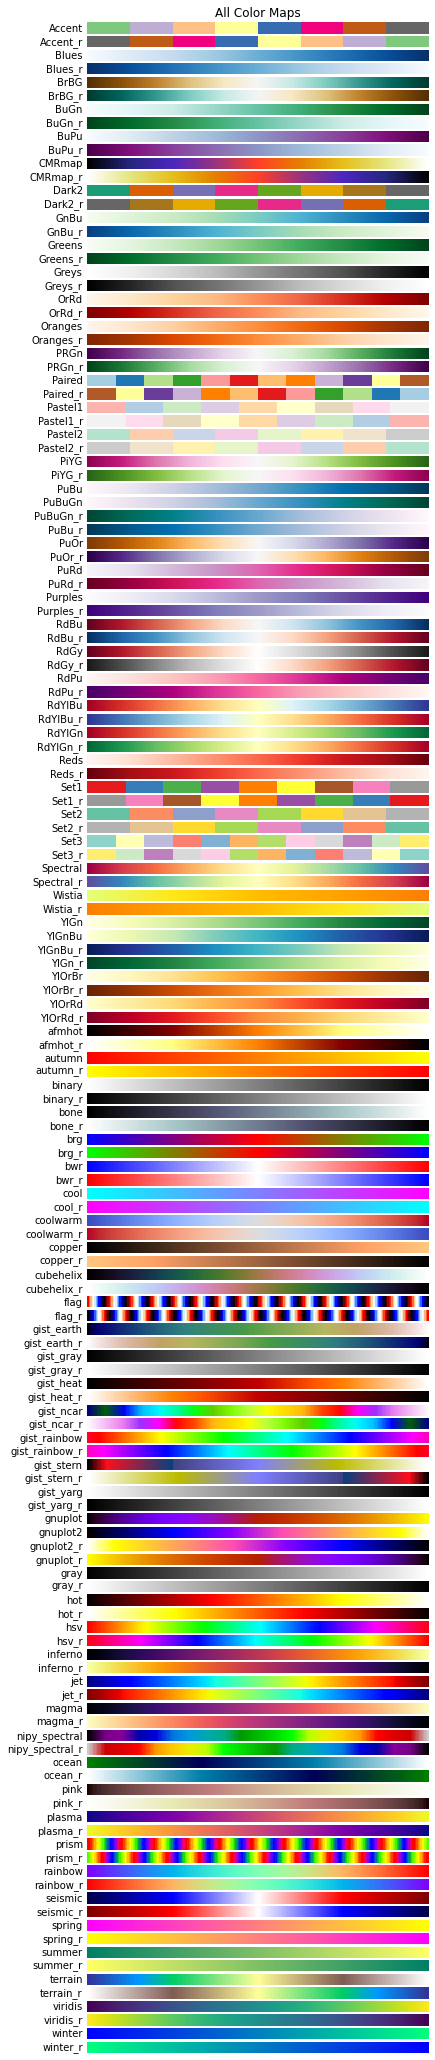

In [162]:
# review color maps available in the `arcgis.mapping` module
from arcgis.mapping import display_colormaps
display_colormaps()

In [160]:
# nj_map3.add_layer(fl_njCounties, {'title':'2012 crime in LA city',
#                        'opacity':0.5,
#                        'visibility':False,
#                         'colors': })

In [167]:
# add layer as choropleth using pop density fields
# nj_map3.add_layer(fl_njCounties)

sdf_njCounties.spatial.plot(kind='map', 
                            map_widget=nj_map3,
                            renderer_type='c', # specify the unique value renderer using its notation 'u'
                            method = 'esriClassifyNaturalBreaks',
                            class_count = 12,
                            cmap="RdPu",
                            alpha="0.5",
                            col='POPDEN2010')  # column to get unique values from

True

In [168]:
nj_map3.legend = True
nj_map3

MapView(jupyter_target='notebook', layout=Layout(height='400px', width='100%'), legend=True, ready=True)

# OLD - 

In [116]:
# import demographics data - population by state
item_id = 'a8407298de7e48078a2bc9cdd76c79af' #2021 USA Population Density
ago_item = my_agol.content.get(item_id)
ago_item

<Item title:"2021 USA Population Density" type:Map Image Layer owner:esri>

In [117]:
us_map = my_gis.map()
#Focus the map to the part of the world containing the example item
us_map.extent = ago_item.extent
us_map

MapView(layout=Layout(height='400px', width='100%'))

In [120]:
# convert from item to feature layer then create local spatial dataframe with point geometry
# fl_pop = ago_item.layers[0] 

us_map.add_layer(ago_item)

Token Required
(Error Code: 499)


Item.layers is a 'NoneType' object: nothing to be added to map


Token Required
(Error Code: 499)
